In [146]:
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt
import torchvision, torch

In [147]:
img_path = "273271-2b427000e2a2b025_jpg.rf.7d933851f233dcd09cf166e310a4b407.jpg" 
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640, 640))
data = np.transpose(img, (2, 0, 1))#hwc to chw
data = np.expand_dims(data, 0)
data = data.astype(np.float32)
data /= 255
data.shape

(1, 3, 640, 640)

In [148]:
raw_yolo = onnxruntime.InferenceSession("models/yolo12l.onnx", providers=['CUDAExecutionProvider'])
yolo_NMSED_onnx = onnxruntime.InferenceSession("onnx_folder/YOLO12_INMSLayer.onnx", providers=['CUDAExecutionProvider'])
# rtdetr_onnx = onnxruntime.InferenceSession("onnx_folder/RTDETR_postprocessed.onnx")
# ensemble_onnx = onnxruntime.InferenceSession("onnx_folder/YOLO12-RTDETR_ensemble_model.onnx")

2025-04-15 02:35:19.321439054 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 4 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2025-04-15 02:35:19.327923321 [W:onnxruntime:, session_state.cc:1263 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-04-15 02:35:19.327937327 [W:onnxruntime:, session_state.cc:1265 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-04-15 02:35:19.549910388 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 4 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on p

In [149]:
out_yolo = yolo_NMSED_onnx.run(None, {yolo_NMSED_onnx.get_inputs()[0].name: data})[0]
raw_out = raw_yolo.run(None, {raw_yolo.get_inputs()[0].name: data})[0].transpose((0,2,1))[0]
bboxes = raw_out[out_yolo[..., 2], :4]
scores = raw_out[out_yolo[..., 2], 4]
bboxes.shape, scores.shape

((58, 4), (58,))

In [145]:
selected_indices = torchvision.ops.nms(torch.tensor(bboxes), torch.tensor(scores), iou_threshold=0.55)
selected_indices = out_yolo[[selected_indices]]
selected_indices.shape

(1, 53, 3)

In [130]:
bboxes.shape

(58, 4)

In [150]:
out_yolo

array([[   0,    0, 7201],
       [   0,    0, 7161],
       [   0,    0, 7404],
       [   0,    0, 7365],
       [   0,    0, 7162],
       [   0,    0, 7405],
       [   0,    0, 7445],
       [   0,    0, 7364],
       [   0,    0, 7241],
       [   0,    0, 7363],
       [   0,    0, 7444],
       [   0,    0, 7443],
       [   0,    0, 7420],
       [   0,    0, 7242],
       [   0,    0, 7160],
       [   0,    0, 7510],
       [   0,    0, 7550],
       [   0,    0, 7370],
       [   0,    0, 7430],
       [   0,    0, 7551],
       [   0,    0, 7471],
       [   0,    0, 7545],
       [   0,    0, 7507],
       [   0,    0, 7409],
       [   0,    0, 7476],
       [   0,    0, 7410],
       [   0,    0, 7496],
       [   0,    0, 7546],
       [   0,    0, 7431],
       [   0,    0, 7369],
       [   0,    0, 7454],
       [   0,    0, 7415],
       [   0,    0, 7459],
       [   0,    0, 7414],
       [   0,    0, 7450],
       [   0,    0, 7472],
       [   0,    0, 7416],
 

In [151]:
cx, cy, w, h = bboxes[:, 0], bboxes[:, 1], bboxes[:, 2], bboxes[:, 3]
x1 = cx - w/2
y1 = cy - h/2
x2 = cx + w/2
y2 = cy + h/2

bboxes = np.stack([x1, y1, x2, y2], axis=1)
bboxes

array([[-8.36181641e-02,  1.65994446e+02,  8.46035995e+01,
         5.14795166e+02],
       [ 1.74179077e-02,  1.65918228e+02,  8.44273605e+01,
         5.15209717e+02],
       [ 2.48776245e+01,  2.54639450e+02,  1.15184906e+02,
         5.68781189e+02],
       [ 2.49440308e+01,  2.54925659e+02,  1.14880875e+02,
         5.69066833e+02],
       [ 7.73315430e-02,  1.65602417e+02,  8.45111237e+01,
         5.14246216e+02],
       [ 2.47829361e+01,  2.54070755e+02,  1.15016121e+02,
         5.68642761e+02],
       [ 2.45698700e+01,  2.54715027e+02,  1.14965698e+02,
         5.68622925e+02],
       [ 2.51031342e+01,  2.54653320e+02,  1.15071930e+02,
         5.69314758e+02],
       [-1.39404297e-01,  1.65872696e+02,  8.41027374e+01,
         5.13913696e+02],
       [ 2.54525032e+01,  2.54858154e+02,  1.15029800e+02,
         5.69074341e+02],
       [ 2.46957855e+01,  2.54768372e+02,  1.15337830e+02,
         5.68563904e+02],
       [ 2.50478897e+01,  2.54855331e+02,  1.15434258e+02,
      

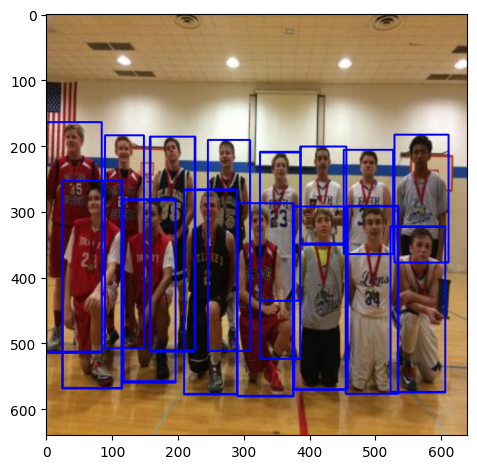

In [152]:
img_yolo = cv2.imread(img_path)
img_yolo = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_yolo = cv2.resize(img, (640, 640))

for box in bboxes:
    cv2.rectangle(img_yolo, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)

plt.imshow(img_yolo)
plt.tight_layout()
plt.show()
